# grok improved version

**V1 Major Improvement**  
1. **Handle Categorical Variables**:  
Use `OneHotEncoder` to transform 'Prime', 'DOMAIN', and 'FRAME' into numerical representations suitable for the model.  
3. **Use a Pipeline**:  
Integrate preprocessing and modeling into a Pipeline to streamline the workflow and prevent data leakage.  
4. **Stratified Splitting**:  
The original code already uses `stratify=y`, which is good for maintaining class balance. We’ll keep this.  
5. **Enhanced Visualizations**:  
Adjust the feature importance plot to reflect the transformed feature names after preprocessing.  
6. **Best Practices**:  
Add better error handling, comments, and cleaner syntax.

**ML5**  
 - using ML5_1 ~ ML5_5 instead ML1~4

Using feature columns: ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5', 'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3', 'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6', 'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_10', 'Rotated_Component_1', 'Rotated_Component_2', 'Rotated_Component_3', 'Rotated_Component_4', 'Rotated_Component_5', 'Rotated_Component_6', 'Rotated_Component_7', 'Rotated_Component_8', 'Rotated_Component_9', 'Rotated_Component_10', 'Prime', 'DOMAIN', 'FRAME']
Encoded classes for 'coding1': ['-1' '1']
Best test split size: 0.2
Best model performance:
  Accuracy: 0.9080234833659491
  F1-score: 0.9405815423514539
  ROC-AUC: 0.9570416954265408
Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


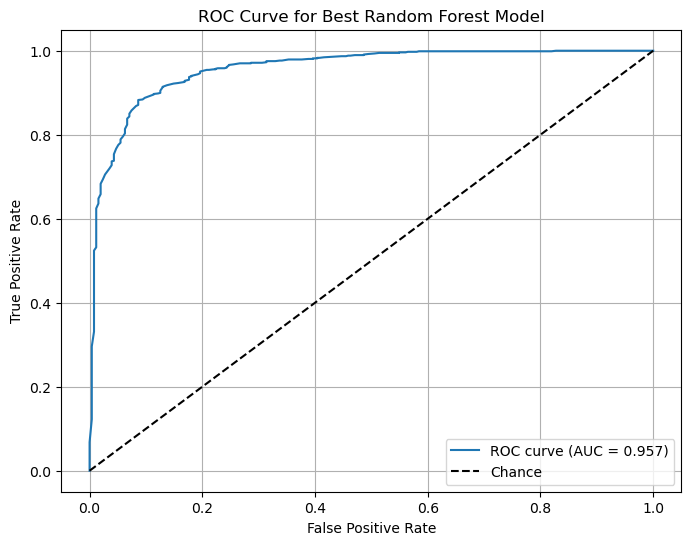

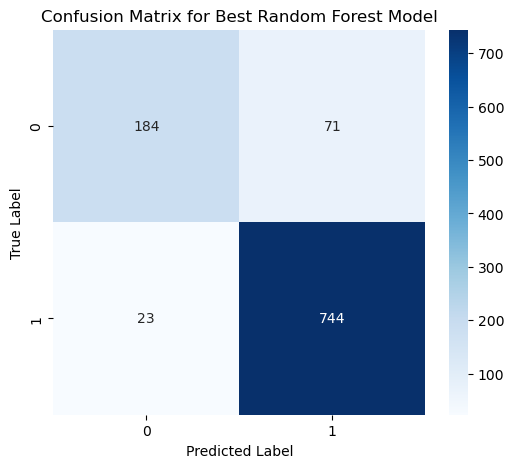

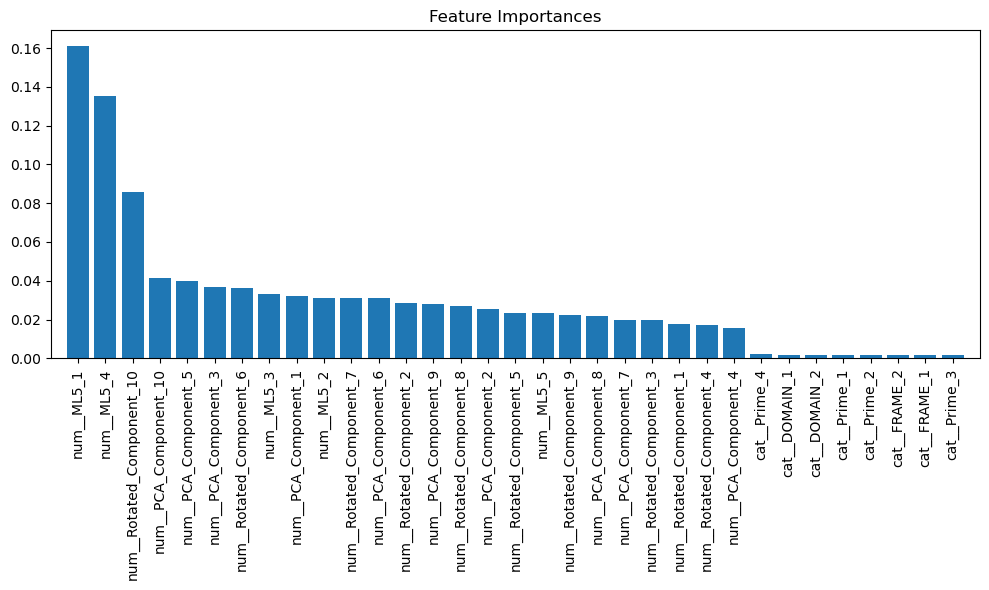

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv(r"V:\20240920\all_in_one_act3301\R_FactorAnalysis\data_all_with_factors_5.csv", 
                 encoding='latin-1', low_memory=False)

# Correct the mistake in the original source file
df['coding1'] = df['coding1'].replace('--1', '-1')

# Filter out rows where the dependent variable 'coding1' is "unknown"
df = df[df['coding1'] != "unknown"]

# Define desired features
desired_features = ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5'] + \
                   [f'PCA_Component_{i}' for i in range(1, 11)] + \
                   [f'Rotated_Component_{i}' for i in range(1, 11)] + \
                   ['Prime', 'DOMAIN', 'FRAME']

feature_cols = [col for col in desired_features if col in df.columns]
print("Using feature columns:", feature_cols)

# Set the dependent variable
target_col = 'coding1'

# Encode the dependent variable (e.g., support -> 1, not support -> 0)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print("Encoded classes for 'coding1':", le.classes_)

# Identify categorical and numerical columns
categorical_cols = ['Prime', 'DOMAIN', 'FRAME']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Create a preprocessor for handling categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Candidate test set sizes to evaluate
test_sizes = [0.2, 0.25, 0.3]
results = []

for test_size in test_sizes:
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_cols], df[target_col], test_size=test_size, random_state=42, stratify=df[target_col]
    )
    
    # Create a pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Perform Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={'classifier__' + k: v for k, v in param_grid.items()},
        cv=5,                       # 5-fold cross-validation
        scoring='accuracy',         # Evaluation metric
        n_jobs=-1                   # Use all available CPU cores
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_pipeline = grid_search.best_estimator_
    best_rf = best_pipeline.named_steps['classifier']
    
    # Make predictions
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': grid_search.best_params_,
        'model': best_rf,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'pipeline': best_pipeline
    })

# Function to compute average score
def avg_score(result):
    return (result['accuracy'] + result['f1_score'] + result['roc_auc']) / 3

# Find the best result
best_result = max(results, key=avg_score)

# Print results
print("Best test split size:", best_result['test_size'])
print("Best model performance:")
print("  Accuracy:", best_result['accuracy'])
print("  F1-score:", best_result['f1_score'])
print("  ROC-AUC:", best_result['roc_auc'])
print("Best hyperparameters:", best_result['best_params'])

# --- Visualization Section ---

# Plot ROC Curve
fpr, tpr, _ = roc_curve(best_result['y_test'], best_result['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {best_result["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Feature Importances
best_model = best_result['model']
importances = best_model.feature_importances_
feature_names = best_result['pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

### 列出不同test_size得到的模型的结果

In [2]:
# results 是保存模型结果的字典列表
extracted_values = []
for result in results:
    test_size = result['test_size']
    accuracy = result['accuracy']
    f1_score = result['f1_score']
    roc_auc = result['roc_auc']
    extracted_values.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'roc_auc': roc_auc
    })

extracted_values

[{'test_size': 0.2,
  'accuracy': 0.9080234833659491,
  'f1_score': 0.9405815423514539,
  'roc_auc': 0.9570416954265408},
 {'test_size': 0.25,
  'accuracy': 0.9045383411580594,
  'f1_score': 0.9383838383838384,
  'roc_auc': 0.951771862670428},
 {'test_size': 0.3,
  'accuracy': 0.9067188519243313,
  'f1_score': 0.9399412011759765,
  'roc_auc': 0.9563809740038598}]